In [1]:
!nvidia-smi

Sat Oct 28 12:13:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P3    16W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

In [21]:
train_path = 'dataset/train/'
val_path = 'dataset/val/'

In [22]:
def sampleImg(num):
    plt.figure(figsize=(6, 6))
    fig, ax = plt.subplots(1, 2)
    img_high_res = cv2.imread(f'dataset/train/high_res/{num}.png')
    img_low_res = cv2.imread(f'dataset/train/low_res/{num}.png')
    ax[0].imshow(img_high_res)
    ax[1].imshow(img_low_res)
    ax[0].set_title(f'High Resolution Image\n{img_high_res.shape}')
    ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
    plt.tight_layout()
    plt.show()

<Figure size 600x600 with 0 Axes>

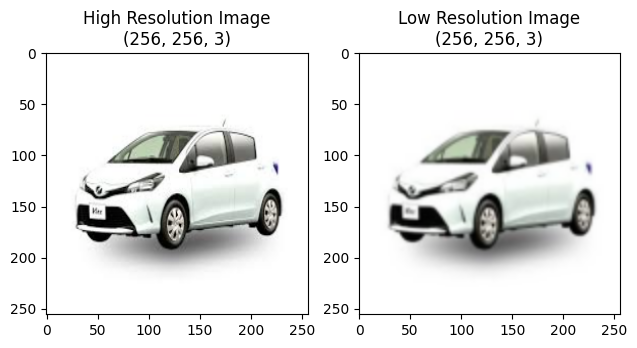

In [23]:
sampleImg(3)

In [74]:
def readImages(path):
    high_res_filenames = os.listdir(path+'/high_res/')
    low_res_filenames = os.listdir(path+'/low_res/')

    X = np.zeros((len(low_res_filenames), 256, 256, 3))
    y = np.zeros((len(high_res_filenames), 256, 256, 3))
    for i, filename in enumerate(high_res_filenames):
        y[i] = cv2.imread(path+'/high_res/'+filename)

    for i, filename in enumerate(low_res_filenames):
        X[i] = cv2.imread(path+'/low_res/'+filename)

    return X/255., y/255.

In [75]:
X_train, y_train = readImages('dataset/train')

In [76]:
X_train.shape, y_train.shape

((685, 256, 256, 3), (685, 256, 256, 3))

In [77]:
X_val, y_val = readImages('dataset/val/')

In [78]:
X_val.shape, y_val.shape

((170, 256, 256, 3), (170, 256, 256, 3))

In [81]:
def getModel(input_shape): 
    input_layer = Input(shape=input_shape, name='Input_Layer')
    x = Conv2D(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2D_1')(input_layer)
    x = MaxPool2D(pool_size=2, name='MaxPool_1')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2D_2')(x)
    x = MaxPool2D(pool_size=2, name='MaxPool_2')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2D_3')(x)
    x = MaxPool2D(pool_size=2, name='MaxPool_3')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='Conv2D_4')(x)
    x = MaxPool2D(pool_size=2, name='MaxPool_4')(x)

    x = Conv2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_1')(x)
    x = UpSampling2D(size=2, name='UpSampling2D_1')(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', name='Conv2DTranspose_2')(x)
    x = UpSampling2D(size=2, name='UpSampling2D_2')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_3')(x)
    x = UpSampling2D(size=2, name='UpSampling2D_3')(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_4')(x)
    x = Conv2DTranspose(filters=3, kernel_size=3, padding='same', strides=2, activation='relu', name='Conv2DTranspose_5')(x)
    
    model = Model(inputs=input_layer, outputs=x, name='Model')
    return model

In [82]:
model = getModel(input_shape=(256,256,3))

In [83]:
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 8, 8, 128)         0     

In [84]:
model.compile(optimizer='adam', loss='mse')

In [85]:
hist = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
18/18 [==============================] - 15s 682ms/step - loss: 0.2028 - val_loss: 0.1340
Epoch 2/50
18/18 [==============================] - 11s 601ms/step - loss: 0.0862 - val_loss: 0.0553
Epoch 3/50
18/18 [==============================] - 11s 601ms/step - loss: 0.0468 - val_loss: 0.0478
Epoch 4/50
18/18 [==============================] - 11s 602ms/step - loss: 0.0401 - val_loss: 0.0393
Epoch 5/50
18/18 [==============================] - 11s 598ms/step - loss: 0.0364 - val_loss: 0.0379
Epoch 6/50
18/18 [==============================] - 11s 596ms/step - loss: 0.0354 - val_loss: 0.0364
Epoch 7/50
18/18 [==============================] - 11s 603ms/step - loss: 0.0324 - val_loss: 0.0335
Epoch 8/50
18/18 [==============================] - 11s 599ms/step - loss: 0.0311 - val_loss: 0.0327
Epoch 9/50
18/18 [==============================] - 11s 596ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 10/50
18/18 [==============================] - 11s 596ms/step - loss: 0.0297 - val_lo

In [86]:
df = pd.DataFrame(hist.history)
df.head()

,loss,val_loss
0,0.202765,0.134008
1,0.086213,0.055263
2,0.046819,0.047783
3,0.040069,0.039311
4,0.036378,0.037928


In [87]:
df.to_csv("model_10_28.csv", index=False)

In [88]:
model.evaluate(X_val, y_val, batch_size=32)

6/6 [==============================] - 1s 182ms/step - loss: 0.0217


0.02173074521124363

In [90]:
model.save("models/model_10_28.h5")

a:\Sem 3\Neural Networks\Project\CSCI-5922-Deep-Learning-Project\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
preds = model.predict(X_val)
preds.shape

6/6 [==============================] - 1s 174ms/step


(170, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 600x600 with 0 Axes>

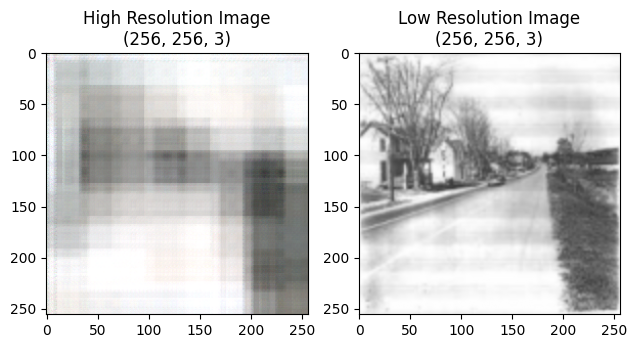

In [92]:
plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(1, 2)
img_high_res = preds[2]
img_low_res = X_val[2]
ax[0].imshow(img_high_res)
ax[1].imshow(img_low_res)
ax[0].set_title(f'High Resolution Image\n{img_high_res.shape}')
ax[1].set_title(f'Low Resolution Image\n{img_low_res.shape}')
plt.tight_layout()
plt.show()